### Импорт библиотек

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg
import os
import random
import tensorflow as tf
import warnings
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from scipy.stats import shapiro, kstest
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime, timedelta
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Input, GRU, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Layer, LSTM, SimpleRNN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import random as tfrandom

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [136]:
# URL для запроса данных
url = "https://api.coingecko.com/api/v3/coins/markets"
params = {
    "vs_currency": "usd",       # Валюта для цены
    "order": "market_cap_desc", # Сортировка по капитализации
    "per_page": 10,             # Количество результатов на странице
    "page": 1                   # Номер страницы
}

# Выполнение GET-запроса
response = requests.get(url, params=params)

# Проверка успешности запроса
if response.status_code == 200:
    data = response.json()
    
    # Извлечение данных о капитализации
    for coin in data:
        name = coin['name']
        symbol = coin['symbol'].upper()
        market_cap = coin['market_cap']
        print(f"{name} ({symbol}): Market Cap = ${market_cap}")
else:
    print(f"Ошибка при запросе: {response.status_code}")

Bitcoin (BTC): Market Cap = $2069179427265
Ethereum (ETH): Market Cap = $304904981497
Tether (USDT): Market Cap = $153184644991
XRP (XRP): Market Cap = $126329207422
BNB (BNB): Market Cap = $95484867222
Solana (SOL): Market Cap = $80052764495
USDC (USDC): Market Cap = $60937405933
Dogecoin (DOGE): Market Cap = $28546497356
TRON (TRX): Market Cap = $25349991033
Cardano (ADA): Market Cap = $24220149612


In [137]:
# Параметры
coin_symbol = "ETH"
currency = "USD"

# URL для получения исторических данных
url = f"https://min-api.cryptocompare.com/data/v2/histoday"
params = {
    "fsym": coin_symbol,  # Символ криптовалюты
    "tsym": currency,     # Валюта для цены
    "limit": 2000,        # Максимальное количество точек данных (2000 ~ 5 лет)
}

# Выполнение запроса
response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    
    # Извлечение данных о ценах закрытия
    prices = data['Data']['Data']
    crypto_data = []
    
    for entry in prices:
        date = datetime.fromtimestamp(entry['time']).strftime('%Y-%m-%d') # Преобразование временной метки в дату
        close_price = entry['close'] # Цена закрытия
        crypto_data.append({
            "Date": date,
            "Price": close_price
        })
    
    # Создание и преобразование DataFrame
    df = pd.DataFrame(crypto_data)
    df["Date"] = pd.to_datetime(df['Date'])
    df_main = df[(df["Date"] >= '2020-01-01') & (df["Date"] < '2025-01-01')]
    df_test = df[(df["Date"] >= '2024-12-02') & (df["Date"] < '2025-01-31')]

    # Проверка на пропущенные значения
    if df_main.isna().sum().sum() == 0:
        df_main.to_csv(f"{coin_symbol}_historical_prices.csv", index=False, encoding="utf-8") # Сохранение DataFrame в CSV-файл
    else:
        print("Ошибка: присутствуют пропущенные значения")

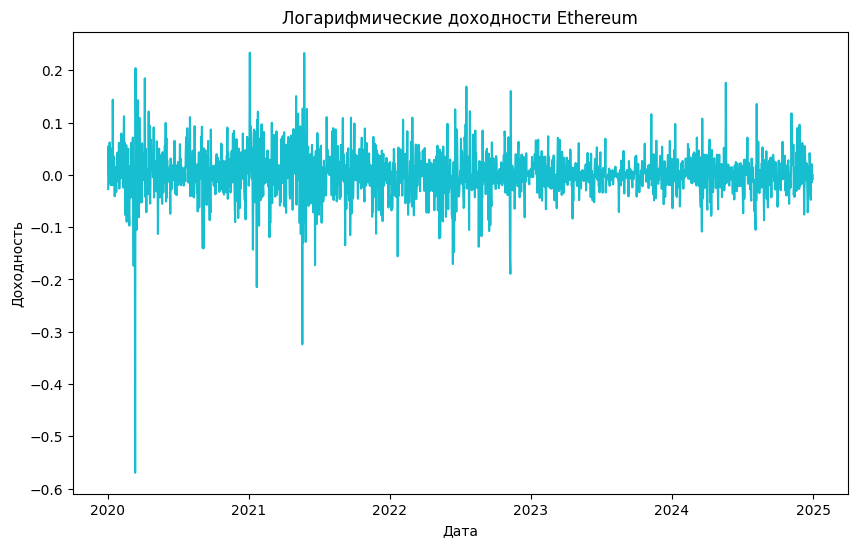

In [138]:
# Загрузка данных (например, цены закрытия Ethereum)
data = pd.read_csv('ETH_historical_prices.csv', parse_dates=['Date'], index_col='Date')
data = data.sort_index()

# Вычисление логарифмических доходностей
data['Log_Returns'] = np.log(data['Price']).diff()

# Удаление пропущенных значений (первое значение будет NaN)
data = data.dropna()

# Визуализация логарифмических доходностей
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Log_Returns'], color='tab:cyan')
plt.title('Логарифмические доходности Ethereum')
plt.xlabel('Дата')
plt.ylabel('Доходность')
plt.show()

In [139]:
# Проверка стационарности с помощью теста Дики-Фуллера
adf_test = adfuller(data['Log_Returns'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] < 0.05:
    print("Временной ряд стационарен")
else:
    print("Временной ряд нестационарен")

ADF Statistic: -12.883060407342679
p-value: 4.6150246821505974e-24
Временной ряд стационарен


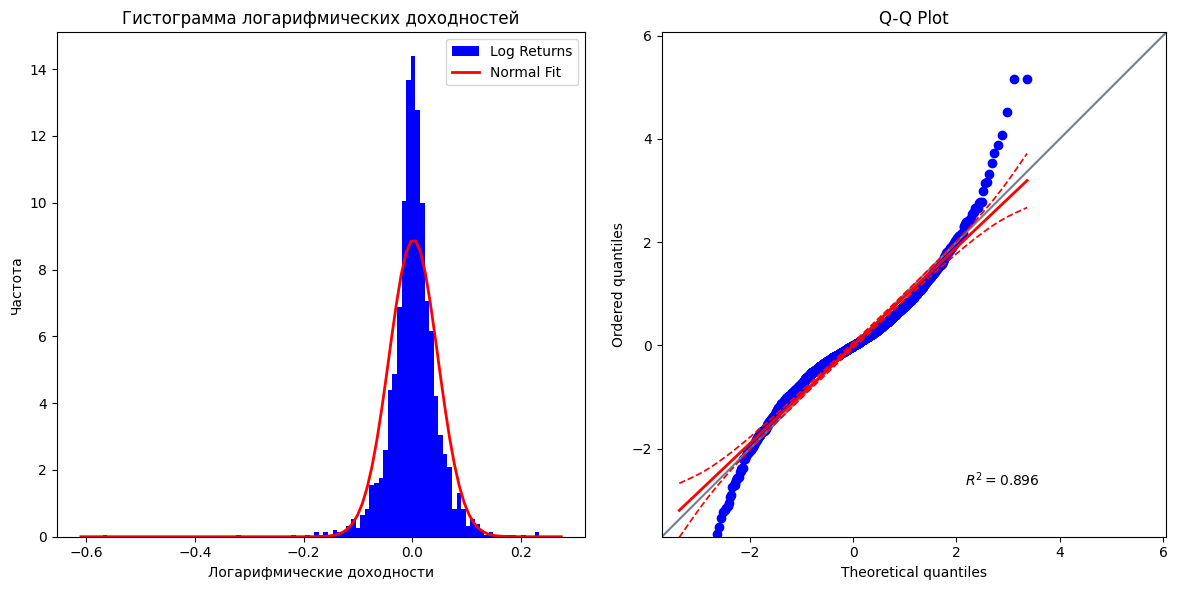

In [140]:
# Построение гистограммы и графика Q-Q
plt.figure(figsize=(12, 6))

# Гистограмма
plt.subplot(121)
plt.hist(data['Log_Returns'], bins=95, density=True, color='blue', label='Log Returns')
plt.title('Гистограмма логарифмических доходностей')
plt.xlabel('Логарифмические доходности')
plt.ylabel('Частота')

# Наложение кривой нормального распределения
mean, std = data['Log_Returns'].mean(), data['Log_Returns'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Fit')

plt.legend()

# График Q-Q
plt.subplot(122)
pg.qqplot(x=data['Log_Returns'])
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [141]:
# Тест Шапиро-Уилка
shapiro_test = shapiro(data['Log_Returns'])
print("Тест Шапиро-Уилка:")
print(f"Статистика: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")
if shapiro_test.pvalue < 0.05:
    print("Отклоняем гипотезу о нормальности.")
else:
    print("Нет оснований отклонять гипотезу о нормальности.")

# Тест Колмогорова-Смирнова
ks_test = kstest(data['Log_Returns'], 'norm', args=(data['Log_Returns'].mean(), data['Log_Returns'].std()))
print("\nТест Колмогорова-Смирнова:")
print(f"Статистика: {ks_test.statistic}, p-value: {ks_test.pvalue}")
if ks_test.pvalue < 0.05:
    print("Отклоняем гипотезу о нормальности.")
else:
    print("Нет оснований отклонять гипотезу о нормальности.")

Тест Шапиро-Уилка:
Статистика: 0.8997403383255005, p-value: 5.621366432555801e-33
Отклоняем гипотезу о нормальности.

Тест Колмогорова-Смирнова:
Статистика: 0.08870434070286207, p-value: 5.959053885598595e-13
Отклоняем гипотезу о нормальности.


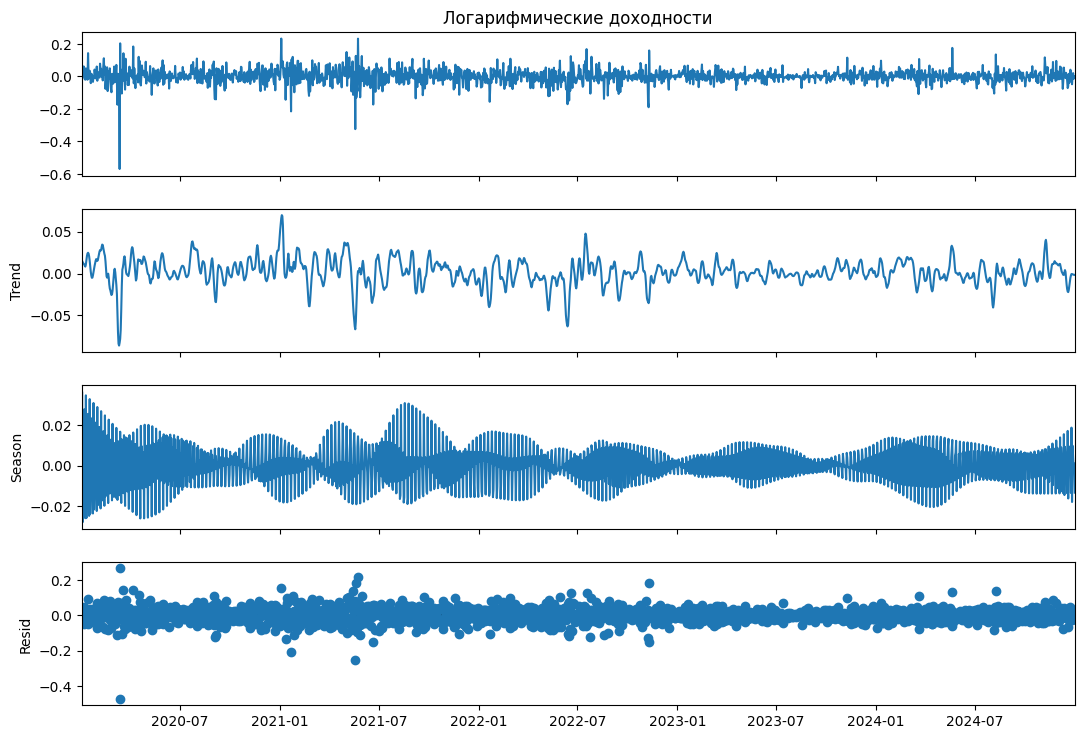

In [142]:
stl = STL(data.rename(columns={'Log_Returns': 'Логарифмические доходности'})['Логарифмические доходности'], seasonal=31)
result = stl.fit()

# Получение компонент
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Отображение графика с увеличенным размером
result.plot().set_size_inches(12, 8) # Устанавливаем размер графика
plt.show()

In [143]:
# Тест Льюнга-Бокса
lb_test = acorr_ljungbox(data['Log_Returns']**2, return_df=True)
print(lb_test)

      lb_stat     lb_pvalue
1   26.122869  3.203670e-07
2   30.290802  2.645062e-07
3   31.239449  7.568684e-07
4   53.853561  5.647663e-11
5   59.614623  1.460036e-11
6   60.668957  3.291246e-11
7   69.247408  2.096694e-12
8   69.315512  6.724828e-12
9   69.698053  1.745035e-11
10  71.915673  1.889293e-11


### Методы математической статистики

Подбор лучших компонент (GARCH)

In [144]:
# Будем тестировать различные комбинации p и q (например, от 0 до 3)
best_aic = np.inf
best_bic = np.inf
best_model = None

for p in range(4):  # Тестируем p от 0 до 3
    for q in range(4):  # Тестируем q от 0 до 3
        try:
            model = arch_model(y=data['Log_Returns'] * 10, mean='Constant', vol='GARCH', p=p, q=q, dist='t')
            result = model.fit(disp='off')
            aic = result.aic
            bic = result.bic
            
            if aic < best_aic:
                best_aic = aic
                best_model = result
                best_pq = (p, q)
            
            print(f"p={p}, q={q}: AIC={aic:.2f}, BIC={bic:.2f}")
        except:
            continue

print(f"\nЛучшая модель: p={best_pq[0]}, q={best_pq[1]} с AIC={best_aic:.2f}")

p=1, q=0: AIC=1752.88, BIC=1774.92
p=1, q=1: AIC=1614.10, BIC=1641.65
p=1, q=2: AIC=1615.13, BIC=1648.19
p=1, q=3: AIC=1615.65, BIC=1654.22
p=2, q=0: AIC=1721.94, BIC=1749.49
p=2, q=1: AIC=1616.10, BIC=1649.16
p=2, q=2: AIC=1617.13, BIC=1655.70
p=2, q=3: AIC=1617.12, BIC=1661.20
p=3, q=0: AIC=1699.15, BIC=1732.21
p=3, q=1: AIC=1618.10, BIC=1656.67
p=3, q=2: AIC=1619.62, BIC=1663.70
p=3, q=3: AIC=1619.12, BIC=1668.71

Лучшая модель: p=1, q=1 с AIC=1614.10


Построение модели (GARCH)

In [145]:
# Предположим, что у нас есть логарифмические доходности в столбце 'Log_Returns'
# Построение базовой модели GARCH(1,1)
basic_garch = arch_model(y=data['Log_Returns'] * 10, mean='Constant', vol='GARCH', p=1, q=1, dist='t')
garch_result = basic_garch.fit(disp='off')  # disp='off' отключает вывод процесса оптимизации

# Вывод результатов модели
print(garch_result.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  Log_Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -802.050
Distribution:      Standardized Student's t   AIC:                           1614.10
Method:                  Maximum Likelihood   BIC:                           1641.65
                                              No. Observations:                 1826
Date:                      Mon, Jun 02 2025   Df Residuals:                     1825
Time:                              18:08:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Подбор лучших компонент (EGARCH)

In [146]:
# Будем тестировать различные комбинации p и q (например, от 0 до 3)
best_aic = np.inf
best_bic = np.inf
best_model = None

for p in range(4):  # Тестируем p от 0 до 3
    for q in range(4):  # Тестируем q от 0 до 3
        try:
            model = arch_model(y=data['Log_Returns'] * 10, mean='Constant', vol='EGARCH', p=p, q=q, dist='t')
            result = model.fit(disp='off')
            aic = result.aic
            bic = result.bic
            
            if aic < best_aic:
                best_aic = aic
                best_model = result
                best_pq = (p, q)
            
            print(f"p={p}, q={q}: AIC={aic:.2f}, BIC={bic:.2f}")
        except:
            continue

print(f"\nЛучшая модель: p={best_pq[0]}, q={best_pq[1]} с AIC={best_aic:.2f}")

p=1, q=0: AIC=1755.62, BIC=1777.66
p=1, q=1: AIC=1592.56, BIC=1620.11
p=1, q=2: AIC=1591.74, BIC=1624.80
p=1, q=3: AIC=1590.65, BIC=1629.22
p=2, q=0: AIC=1733.11, BIC=1760.66
p=2, q=1: AIC=1589.03, BIC=1622.09
p=2, q=2: AIC=1591.03, BIC=1629.60
p=2, q=3: AIC=1591.75, BIC=1635.83
p=3, q=0: AIC=1717.56, BIC=1750.62
p=3, q=1: AIC=1590.17, BIC=1628.74
p=3, q=2: AIC=1591.90, BIC=1635.98
p=3, q=3: AIC=1593.38, BIC=1642.96

Лучшая модель: p=2, q=1 с AIC=1589.03


Построение модели (EGARCH)

In [147]:
# Предположим, что у нас есть логарифмические доходности в столбце 'Log_Returns'
# Построение базовой модели GARCH(1,1)
basic_egarch = arch_model(y=data['Log_Returns'] * 10, mean='Constant', vol='EGARCH', p=2, q=1, dist='t')
egarch_result = basic_egarch.fit(disp='off')  # disp='off' отключает вывод процесса оптимизации

# Вывод результатов модели
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                  Log_Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -788.517
Distribution:      Standardized Student's t   AIC:                           1589.03
Method:                  Maximum Likelihood   BIC:                           1622.09
                                              No. Observations:                 1826
Date:                      Mon, Jun 02 2025   Df Residuals:                     1825
Time:                              18:08:43   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Разные временные окна

In [148]:
data_test = data.copy()

# Создаем списки для хранения результатов
results = []

for window in range(3, 31):

    data_test['Historical_Volatility'] = data_test['Log_Returns'].rolling(window=window).std()
    data_test['GARCH_Volatility'] = garch_result.conditional_volatility
    data_test['EGARCH_Volatility'] = egarch_result.conditional_volatility

    # Создаем дополнительный датафрейм
    data_example = data_test.reset_index()

    # Удаляем NaN (первые `window-1` значений скользящей волатильности)
    rolling_vol_valid = data_test['Historical_Volatility'].dropna()
    conditional_vol_valid_garch = data_example[data_example['Date'] >= (pd.to_datetime('2020-01-01') + pd.Timedelta(days=window))]['GARCH_Volatility'] / 10
    conditional_vol_valid_egarch = data_example[data_example['Date'] >= (pd.to_datetime('2020-01-01') + pd.Timedelta(days=window))]['EGARCH_Volatility'] / 10

    # Расчет метрик
    metrics = {
        'Window': window,
        'GARCH_RMSE': np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_garch)),
        'EGARCH_RMSE': np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_egarch)),
        'GARCH_R2': r2_score(rolling_vol_valid, conditional_vol_valid_garch),
        'EGARCH_R2': r2_score(rolling_vol_valid, conditional_vol_valid_egarch),
        'GARCH_MAE': mean_absolute_error(rolling_vol_valid, conditional_vol_valid_garch),
        'EGARCH_MAE': mean_absolute_error(rolling_vol_valid, conditional_vol_valid_egarch),
        'GARCH_MAPE': mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_garch),
        'EGARCH_MAPE': mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_egarch)
    }
    results.append(metrics)

    # Создаем DataFrame из результатов
    results_df = pd.DataFrame(results)

    # Формируем столбцы для финального сравнения
    results_df['RMSE'] = results_df.apply(
        lambda row: 'GARCH' if row['GARCH_RMSE'] < row['EGARCH_RMSE'] else 'EGARCH', axis=1)
    results_df['R2'] = results_df.apply(
        lambda row: 'GARCH' if row['GARCH_R2'] > row['EGARCH_R2'] else 'EGARCH', axis=1)
    results_df['MAE'] = results_df.apply(
        lambda row: 'GARCH' if row['GARCH_MAE'] < row['EGARCH_MAE'] else 'EGARCH', axis=1)
    results_df['MAPE'] = results_df.apply(
        lambda row: 'GARCH' if row['GARCH_MAPE'] < row['EGARCH_MAPE'] else 'EGARCH', axis=1)

results_df

,Window,GARCH_RMSE,EGARCH_RMSE,GARCH_R2,EGARCH_R2,GARCH_MAE,EGARCH_MAE,GARCH_MAPE,EGARCH_MAPE,RMSE,R2,MAE,MAPE
0,3,0.024947,0.024219,0.260174,0.302744,0.018272,0.017704,1.177454,1.126584,EGARCH,EGARCH,EGARCH,EGARCH
1,4,0.020835,0.020904,0.398771,0.394788,0.015040,0.014941,0.757339,0.729690,GARCH,GARCH,EGARCH,EGARCH
2,5,0.018183,0.018762,0.486533,0.453328,0.013037,0.013313,0.583465,0.570112,GARCH,GARCH,GARCH,EGARCH
3,6,0.016230,0.017221,0.559455,0.504025,0.011535,0.012069,0.474812,0.471592,GARCH,GARCH,GARCH,EGARCH
4,7,0.014752,0.016096,0.614354,0.540856,0.010420,0.011202,0.407205,0.411297,GARCH,GARCH,GARCH,GARCH
5,8,0.013647,0.015302,0.656246,0.567821,0.009657,0.010564,0.364272,0.372542,GARCH,GARCH,GARCH,GARCH
6,9,0.012621,0.014475,0.695469,0.599425,0.008976,0.009976,0.329806,0.340928,GARCH,GARCH,GARCH,GARCH
7,10,0.011696,0.013819,0.729890,0.622909,0.008383,0.009504,0.302444,0.316411,GARCH,GARCH,GARCH,GARCH
8,11,0.011000,0.013315,0.753930,0.639409,0.007933,0.009150,0.281776,0.297585,GARCH,GARCH,GARCH,GARCH
9,12,0.010407,0.012806,0.774055,0.657893,0.007550,0.008802,0.264171,0.280500,GARCH,GARCH,GARCH,GARCH


Сравнительная визуализация моделей с исходными логарифмическими доходностями с окном 20 дней

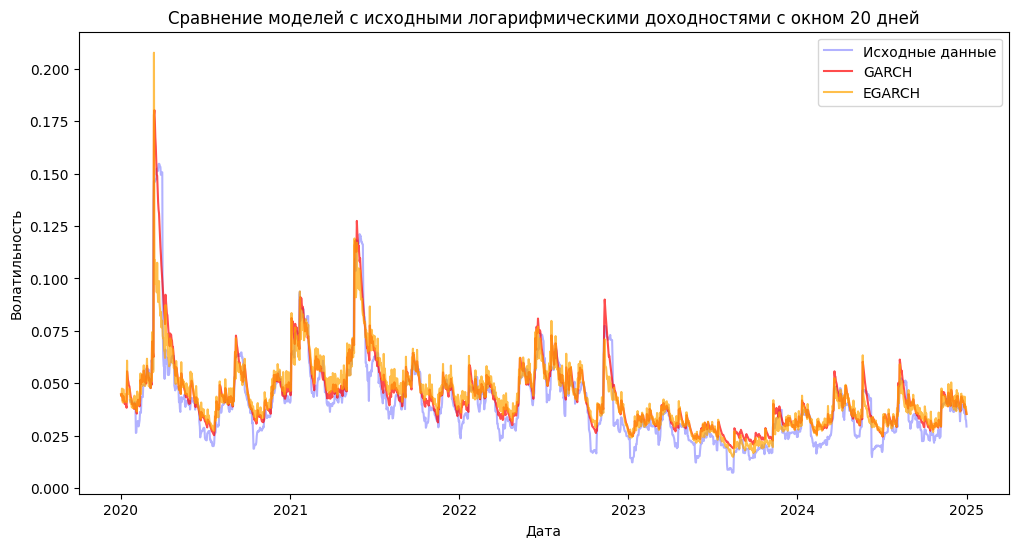

In [149]:
# Рассчитываем исходную волатильность с окном 20 дней
window = 20
data['Historical_Volatility'] = data['Log_Returns'].rolling(window=window).std()

# Условная волатильность из модели GARCH
data['GARCH_Volatility'] = garch_result.conditional_volatility

# Условная волатильность из модели EGARCH
data['EGARCH_Volatility'] = egarch_result.conditional_volatility

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Historical_Volatility'], label='Исходные данные', color='blue', alpha=0.3)
plt.plot(data.index, data['GARCH_Volatility'] / 10, label='GARCH', color='red', alpha=0.7)
plt.plot(data.index, data['EGARCH_Volatility'] / 10, label='EGARCH', color='orange', alpha=0.7)
plt.title('Сравнение моделей с исходными логарифмическими доходностями c окном 20 дней')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.show()

Количественная оценка моделей

In [150]:
# Создаем дополнительный датафрейм
data_example = data.reset_index()

# Удаляем NaN (первые `window-1` значений скользящей волатильности)
rolling_vol_valid = data['Historical_Volatility'].dropna()
conditional_vol_valid_garch = data_example[data_example['Date'] >= pd.to_datetime('2020-01-21')]['GARCH_Volatility'] / 10
conditional_vol_valid_egarch = data_example[data_example['Date'] >= pd.to_datetime('2020-01-21')]['EGARCH_Volatility'] / 10

# Считаем метрики GARCH
rmse_garch = np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_garch))
r2_garch = r2_score(rolling_vol_valid, conditional_vol_valid_garch)
mae_garch = mean_absolute_error(rolling_vol_valid, conditional_vol_valid_garch)
mape_garch = mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_garch)

# Считаем метрики EGARCH
rmse_egarch = np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_egarch))
r2_egarch = r2_score(rolling_vol_valid, conditional_vol_valid_egarch)
mae_egarch = mean_absolute_error(rolling_vol_valid, conditional_vol_valid_egarch)
mape_egarch = mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_egarch)

print('GARCH & EGARCH')
print(f"RMSE: {rmse_garch:.4f} | {rmse_egarch:.4f}")
print(f"R²: {r2_garch:.4f} | {r2_egarch:.4f}")
print(f"MAE: {mae_garch:.4f} | {mae_egarch:.4f}")
print(f"MAPE: {mape_garch:.4f} | {mape_egarch:.4f}")

GARCH & EGARCH
RMSE: 0.0079 | 0.0103
R²: 0.8492 | 0.7441
MAE: 0.0060 | 0.0071
MAPE: 0.1900 | 0.2036


Сравнительная визуализация моделей с исходными логарифмическими доходностями с окном 30 дней

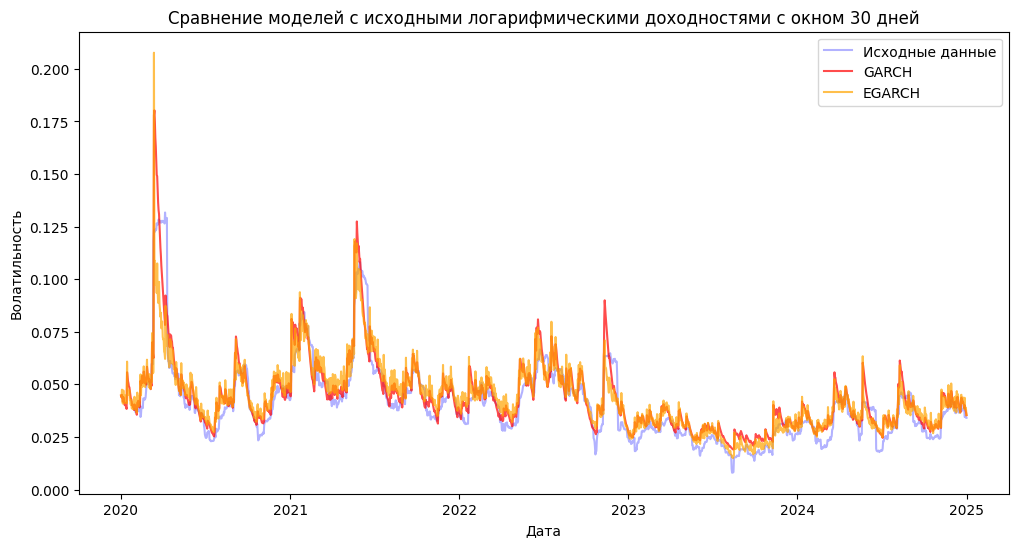

In [151]:
# Рассчитываем исходную волатильность с окном 30 дней
window = 30
data['Historical_Volatility'] = data['Log_Returns'].rolling(window=window).std()

# Условная волатильность из модели GARCH
data['GARCH_Volatility'] = garch_result.conditional_volatility

# Условная волатильность из модели EGARCH
data['EGARCH_Volatility'] = egarch_result.conditional_volatility

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Historical_Volatility'], label='Исходные данные', color='blue', alpha=0.3)
plt.plot(data.index, data['GARCH_Volatility'] / 10, label='GARCH', color='red', alpha=0.7)
plt.plot(data.index, data['EGARCH_Volatility'] / 10, label='EGARCH', color='orange', alpha=0.7)
plt.title('Сравнение моделей с исходными логарифмическими доходностями c окном 30 дней')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.show()

Количественная оценка моделей

In [152]:
# Создаем дополнительный датафрейм
data_example = data.reset_index()

# Удаляем NaN (первые `window-1` значений скользящей волатильности)
rolling_vol_valid = data['Historical_Volatility'].dropna()
conditional_vol_valid_garch = data_example[data_example['Date'] >= pd.to_datetime('2020-01-31')]['GARCH_Volatility'] / 10
conditional_vol_valid_egarch = data_example[data_example['Date'] >= pd.to_datetime('2020-01-31')]['EGARCH_Volatility'] / 10

# Считаем метрики GARCH
rmse_garch = np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_garch))
r2_garch = r2_score(rolling_vol_valid, conditional_vol_valid_garch)
mae_garch = mean_absolute_error(rolling_vol_valid, conditional_vol_valid_garch)
mape_garch = mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_garch)

# Считаем метрики EGARCH
rmse_egarch = np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_egarch))
r2_egarch = r2_score(rolling_vol_valid, conditional_vol_valid_egarch)
mae_egarch = mean_absolute_error(rolling_vol_valid, conditional_vol_valid_egarch)
mape_egarch = mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_egarch)

print('GARCH & EGARCH')
print(f"RMSE: {rmse_garch:.4f} | {rmse_egarch:.4f}")
print(f"R²: {r2_garch:.4f} | {r2_egarch:.4f}")
print(f"MAE: {mae_garch:.4f} | {mae_egarch:.4f}")
print(f"MAPE: {mape_garch:.4f} | {mape_egarch:.4f}")

GARCH & EGARCH
RMSE: 0.0084 | 0.0093
R²: 0.8088 | 0.7611
MAE: 0.0061 | 0.0063
MAPE: 0.1679 | 0.1665


Проверка остатков моделей на автокорреляцию

In [153]:
std_resid = garch_result.resid / garch_result.conditional_volatility
lb_test = round(acorr_ljungbox(std_resid, lags=[10]), 2)
print(lb_test.lb_pvalue)

10    0.07
Name: lb_pvalue, dtype: float64


In [154]:
std_resid = egarch_result.resid / egarch_result.conditional_volatility
lb_test = round(acorr_ljungbox(std_resid, lags=[10]), 2)
print(lb_test.lb_pvalue)

10    0.05
Name: lb_pvalue, dtype: float64


Прогнозирование волатильности

In [155]:
# Прогноз на 30 дней вперёд
forecasts_garch = garch_result.forecast(horizon=30, reindex=False)
conditional_volatility_garch = np.sqrt(forecasts_garch.variance.iloc[-1]) / 10

forecasts_egarch = egarch_result.forecast(horizon=30, reindex=False, method='bootstrap')
conditional_volatility_egarch = np.sqrt(forecasts_egarch.variance.iloc[-1]) / 10

In [156]:
# Начальная дата
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 1, 30)

date_list = []
current_date = start_date

while current_date <= end_date:
    date_list.append(current_date.strftime('%Y-%m-%d'))  # Форматируем дату как строку
    current_date += timedelta(days=1)  # Увеличиваем дату на один день

forecast_data = pd.DataFrame({'Date': date_list, 'GARCH': conditional_volatility_garch, 'EGARCH': conditional_volatility_egarch})
forecast_data['Date'] = pd.to_datetime(forecast_data['Date'])
forecast_data.set_index('Date', inplace=True)

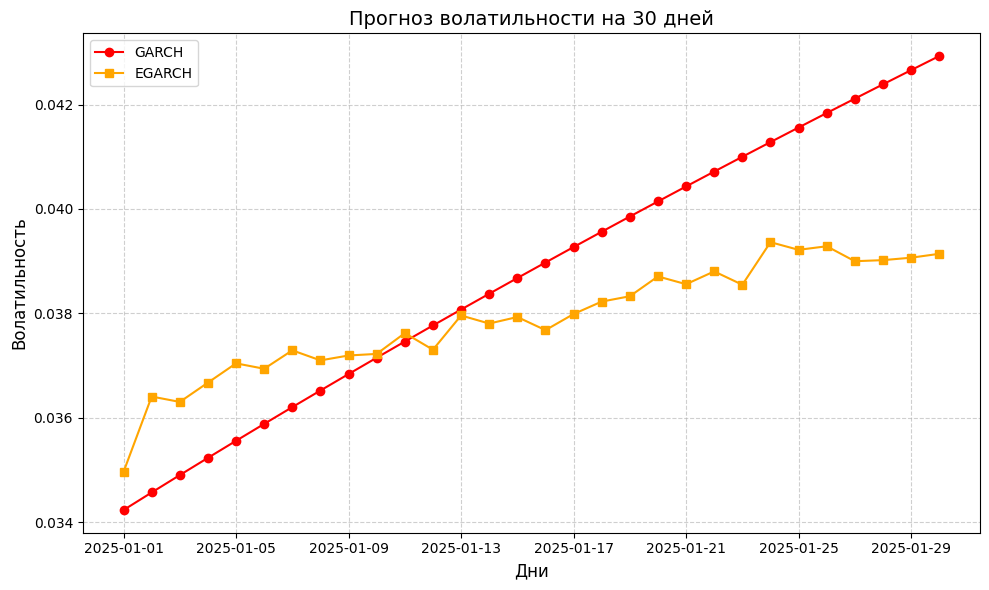

In [157]:
# Создание графика
plt.figure(figsize=(10, 6))  # Размер графика

# Построение линий
plt.plot(forecast_data['GARCH'], color='red', marker='o', label='GARCH')
plt.plot(forecast_data['EGARCH'], color='orange', marker='s', label='EGARCH')

# Настройка осей
plt.xlabel('Дни', fontsize=12)
plt.ylabel('Волатильность', fontsize=12)
plt.title('Прогноз волатильности на 30 дней', fontsize=14)

# Добавление легенды
plt.legend(fontsize=10)

# Настройка сетки
plt.grid(True, linestyle='--', alpha=0.6)

# Сохранение или отображение графика
plt.tight_layout()  # Автоматическое выравнивание компонентов графика
plt.show()

Сравнение прогноза с реальными данными

In [ ]:
# Вычисление логарифмических доходностей
df_test['Log_Returns'] = np.log(df_test['Price']).diff()

# Удаление пропущенных значений (первое значение будет NaN)
df_test = df_test.dropna()

# # Определение волатильности
df_test['Historical_Volatility'] = df_test['Log_Returns'].rolling(window=30).std()

# Удаление пропущенных значений
df_test.dropna(inplace=True)

# Изменение индекса
df_test.set_index('Date', inplace=True)

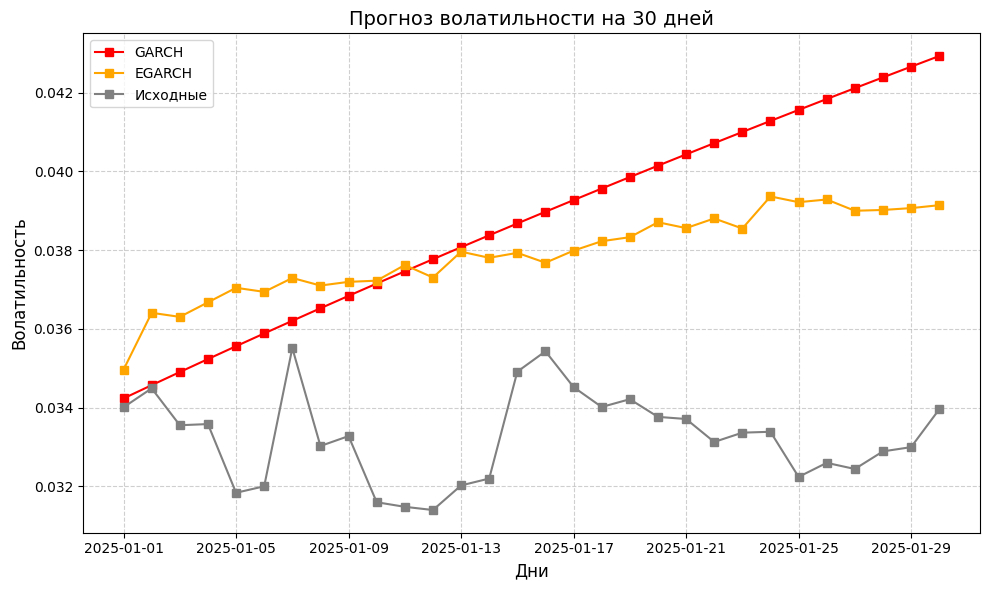

In [159]:
# Создание графика
plt.figure(figsize=(10, 6))  # Размер графика

# Построение линий
plt.plot(forecast_data['GARCH'], color='red', marker='s', label='GARCH')
plt.plot(forecast_data['EGARCH'], color='orange', marker='s', label='EGARCH')
plt.plot(df_test['Historical_Volatility'], color='gray', marker='s', label='Исходные')

# Настройка осей
plt.xlabel('Дни', fontsize=12)
plt.ylabel('Волатильность', fontsize=12)
plt.title('Прогноз волатильности на 30 дней', fontsize=14)

# Добавление легенды
plt.legend(fontsize=10)

# Настройка сетки
plt.grid(True, linestyle='--', alpha=0.6)

# Сохранение или отображение графика
plt.tight_layout()  # Автоматическое выравнивание компонентов графика
plt.show()

### Методы машинного обучения

RNN

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2196 - mae: 0.3194 - val_loss: 5.1253e-04 - val_mae: 0.0175 - learning_rate: 0.0013
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0169 - mae: 0.0893 - val_loss: 3.6009e-04 - val_mae: 0.0151 - learning_rate: 0.0013
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0107 - mae: 0.0730 - val_loss: 1.6920e-04 - val_mae: 0.0091 - learning_rate: 0.0013
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - mae: 0.0604 - val_loss: 2.3935e-04 - val_mae: 0.0121 - learning_rate: 0.0013
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0054 - mae: 0.0533 - val_loss: 1.4307e-04 - val_mae: 0.0075 - learning_rate: 0.0013
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - mae: 0.0517 - val_loss: 2.4325e-04 - val_mae: 0.0121 - learning_rate: 0.0013
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - mae: 0.0490 - val_loss: 1.3333e-04 - val_mae:

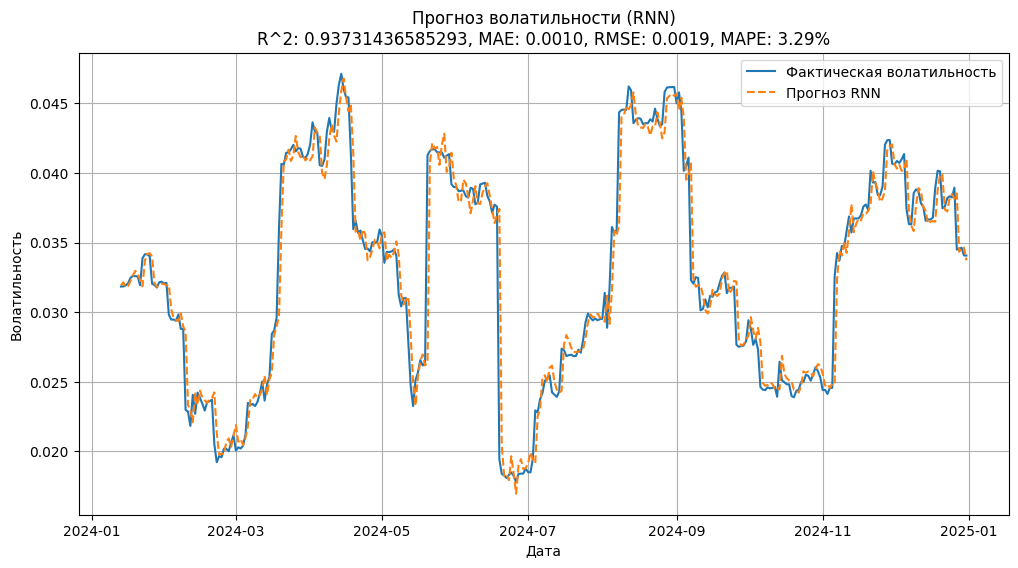

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━

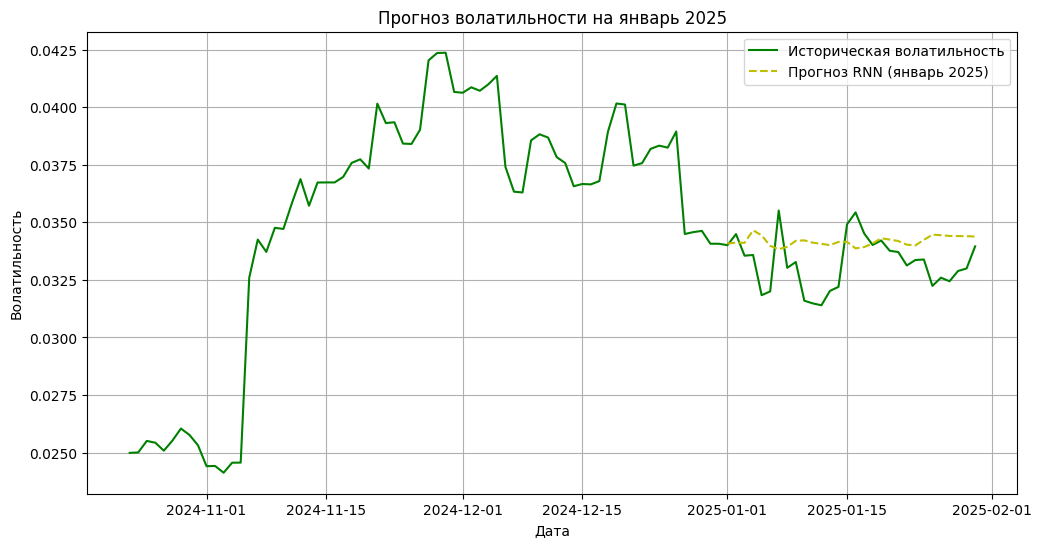

In [160]:
# Установка SEED для воспроизводимости
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tfrandom.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Отключаем GPU для детерминированности

# Нормализация данных (масштабирование к [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Historical_Volatility']].dropna().values)

# Подготовка данных для RNN (X = предыдущие значения, y = следующее значение)
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 30  # Используем 30 предыдущих дней для прогноза
X, y = create_dataset(scaled_data, look_back)

# Разделение на обучающую и тестовую выборки (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape для RNN: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Создание модели RNN
model = Sequential([
    SimpleRNN(units=128, return_sequences=True, input_shape=(look_back, 1)), # 50 было
    Dropout(0.1), # 0.3 было
    SimpleRNN(units=61), # 50 было
    Dropout(0.5), # 0.3 было 
    Dense(units=1)
])

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.00128), # 0005 было
    loss='mean_squared_error',  # Менее чувствительна к выбросам чем MSE
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Обучение
history = model.fit(
    X_train, y_train,
    epochs=100, # 100 было
    batch_size=8,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Обратное масштабирование данных
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Оценка модели
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100  # В процентах

print(f"\nОценка модели RNN:")
print(f"- R^2: {r2:.6f}")
print(f"- MAE: {mae:.6f}")
print(f"- RMSE: {rmse:.6f}")
print(f"- MAPE: {mape:.2f}%")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_actual, label='Фактическая волатильность')
plt.plot(data.index[-len(y_test):], y_pred_actual, label='Прогноз RNN', linestyle='--')
plt.title(f"Прогноз волатильности (RNN)\nR^2: {r2}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid()
plt.show()

# Прогноз на 30 дней вперед (январь 2025)
def forecast_future(model, initial_sequence, steps=30):
    future_predictions = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(steps):
        next_pred = model.predict(current_sequence.reshape(1, look_back, 1))
        future_predictions.append(next_pred)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    
    return future_predictions

# Берем последние `look_back` значений для прогноза
last_sequence = scaled_data[-look_back:]
future_volatility_scaled = forecast_future(model, last_sequence, steps=30)
future_volatility = scaler.inverse_transform(np.array(future_volatility_scaled).reshape(-1, 1))

# Даты для будущего прогноза
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Формирование единого датасета
union_data = pd.concat([data[['Price', 'Log_Returns', 'Historical_Volatility']], df_test])

# Оценка прогноза
data_for_marks = union_data.reset_index().query('Date >= "2025-01-01"')
r2 = r2_score(data_for_marks['Historical_Volatility'], future_volatility)
mae = mean_absolute_error(data_for_marks['Historical_Volatility'], future_volatility)
rmse = np.sqrt(mean_squared_error(data_for_marks['Historical_Volatility'], future_volatility))
mape = mean_absolute_percentage_error(data_for_marks['Historical_Volatility'], future_volatility) * 100  # В процентах

print(f"\nОценка модели RNN:")
print(f"- R^2: {r2:.6f}")
print(f"- MAE: {mae:.6f}")
print(f"- RMSE: {rmse:.6f}")
print(f"- MAPE: {mape:.2f}%")

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(union_data.index[-100:], union_data[['Historical_Volatility']].dropna().values[-100:], label='Историческая волатильность', color='g')
plt.plot(future_dates, future_volatility, '--y', label='Прогноз RNN (январь 2025)')
plt.title('Прогноз волатильности на январь 2025')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid()
plt.show()

LSTM

Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.6424 - mae: 0.4848 - val_loss: 0.0513 - val_mae: 0.1920 - learning_rate: 5.0000e-04
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.1638 - mae: 0.2415 - val_loss: 0.0428 - val_mae: 0.1740 - learning_rate: 5.0000e-04
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1096 - mae: 0.1954 - val_loss: 0.0417 - val_mae: 0.1722 - learning_rate: 5.0000e-04
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1026 - mae: 0.1754 - val_loss: 0.0295 - val_mae: 0.1418 - learning_rate: 5.0000e-04
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0944 - mae: 0.1702 - val_loss: 0.0113 - val_mae: 0.0789 - learning_rate: 5.0000e-04
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0885 - mae: 0.1729 - val_loss: 0.0137 - val_mae: 0.0884 - learning_rate: 5.0000e-04
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0814 - mae: 0.1623 - val_loss: 0.0124 - val_mae: 0.0829 - lear

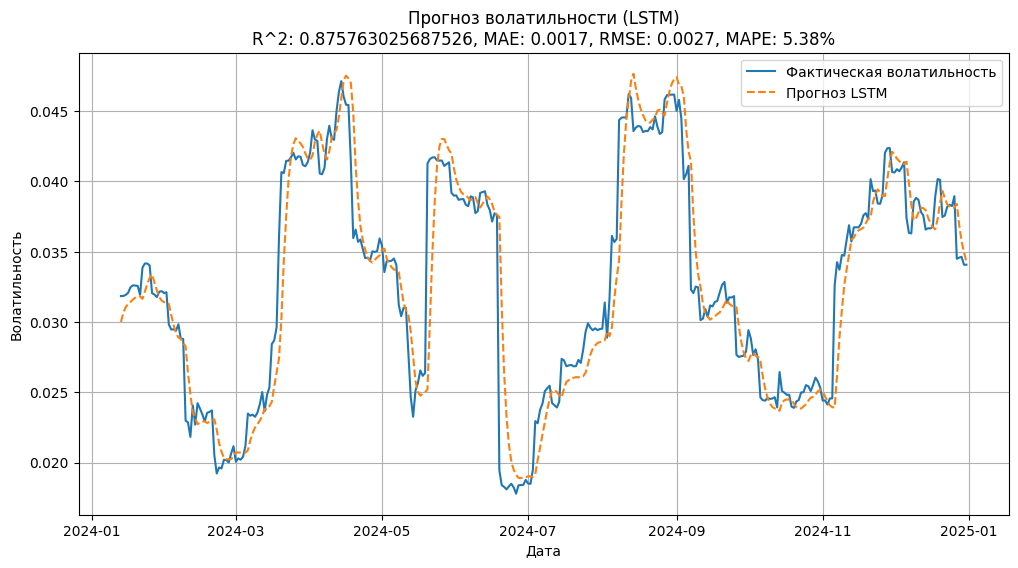

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━

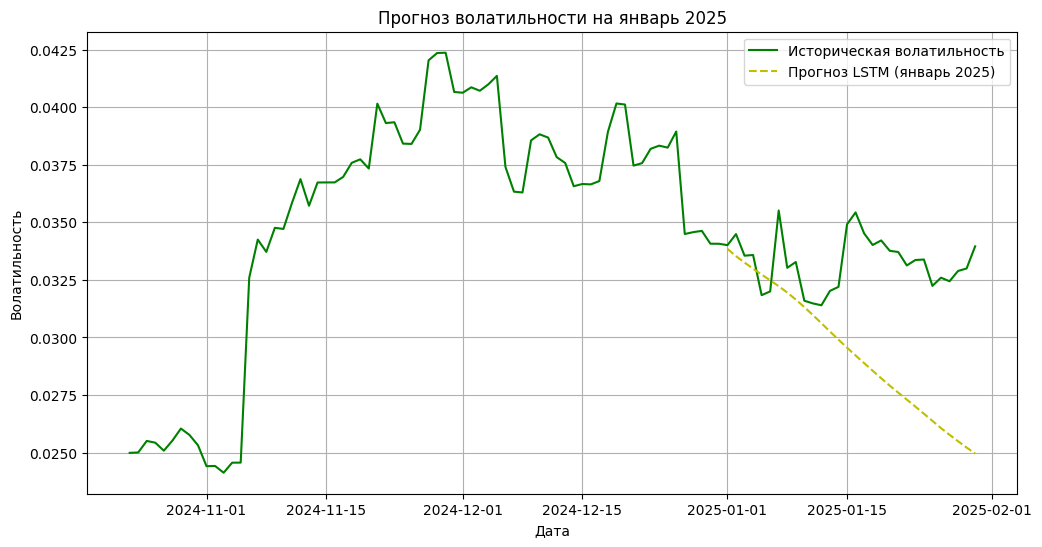

In [161]:
# Установка SEED для воспроизводимости
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tfrandom.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Отключаем GPU для детерминированности

# Нормализация данных (масштабирование к [0, 1])
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data[['Historical_Volatility']].dropna().values)

# Подготовка данных для LSTM (X = предыдущие значения, y = следующее значение)
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 30  # Используем 30 предыдущих дней для прогноза
X, y = create_dataset(scaled_data, look_back)

# Разделение на обучающую и тестовую выборки (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape для LSTM: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Создание LSTM-модели
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(look_back, 1)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1)
])

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.0005), # 0005 было
    loss='mean_squared_error',  # Менее чувствительна к выбросам чем MSE
    metrics=['mae']
)

# Callback'и
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Обучение
history = model.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Обратное масштабирование данных
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Оценка модели
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100  # В процентах

print(f"\nОценка модели LSTM:")
print(f"- R^2: {r2:.6f}")
print(f"- MAE: {mae:.6f}")
print(f"- RMSE: {rmse:.6f}")
print(f"- MAPE: {mape:.2f}%")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_actual, label='Фактическая волатильность')
plt.plot(data.index[-len(y_test):], y_pred_actual, label='Прогноз LSTM', linestyle='--')
plt.title(f"Прогноз волатильности (LSTM)\nR^2: {r2}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid()
plt.show()

# Прогноз на 30 дней вперед (январь 2025)
def forecast_future(model, initial_sequence, steps=30):
    future_predictions = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(steps):
        next_pred = model.predict(current_sequence.reshape(1, look_back, 1))
        future_predictions.append(next_pred)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    
    return future_predictions

# Берем последние `look_back` значений для прогноза
last_sequence = scaled_data[-look_back:]
future_volatility_scaled = forecast_future(model, last_sequence, steps=30)
future_volatility = scaler.inverse_transform(np.array(future_volatility_scaled).reshape(-1, 1))

# Даты для будущего прогноза
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Формирование единого датасета
union_data = pd.concat([data[['Price', 'Log_Returns', 'Historical_Volatility']], df_test])

# Оценка прогноза
data_for_marks = union_data.reset_index().query('Date >= "2025-01-01"')
r2 = r2_score(data_for_marks['Historical_Volatility'], future_volatility)
mae = mean_absolute_error(data_for_marks['Historical_Volatility'], future_volatility)
rmse = np.sqrt(mean_squared_error(data_for_marks['Historical_Volatility'], future_volatility))
mape = mean_absolute_percentage_error(data_for_marks['Historical_Volatility'], future_volatility) * 100  # В процентах

print(f"\nОценка модели LSTM:")
print(f"- R^2: {r2:.6f}")
print(f"- MAE: {mae:.6f}")
print(f"- RMSE: {rmse:.6f}")
print(f"- MAPE: {mape:.2f}%")

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(union_data.index[-100:], union_data[['Historical_Volatility']].dropna().values[-100:], label='Историческая волатильность', color='g')
plt.plot(future_dates, future_volatility, '--y', label='Прогноз LSTM (январь 2025)')
plt.title('Прогноз волатильности на январь 2025')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid()
plt.show()

GRU

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.7963 - mae: 0.5393 - val_loss: 0.0125 - val_mae: 0.0843 - learning_rate: 5.0000e-04
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1606 - mae: 0.2251 - val_loss: 0.0109 - val_mae: 0.0773 - learning_rate: 5.0000e-04
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1413 - mae: 0.1992 - val_loss: 0.0122 - val_mae: 0.0818 - learning_rate: 5.0000e-04
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0881 - mae: 0.1617 - val_loss: 0.0137 - val_mae: 0.0892 - learning_rate: 5.0000e-04
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0874 - mae: 0.1540 - val_loss: 0.0113 - val_mae: 0.0789 - learning_rate: 5.0000e-04
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0724 - mae: 0.1464 - val_loss: 0.0134 - val_mae: 0.0899 - learning_rate: 5.0000e-04
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0723 - mae: 0.1501 - val_loss: 0.0131 - val_mae: 0.0890 - lear

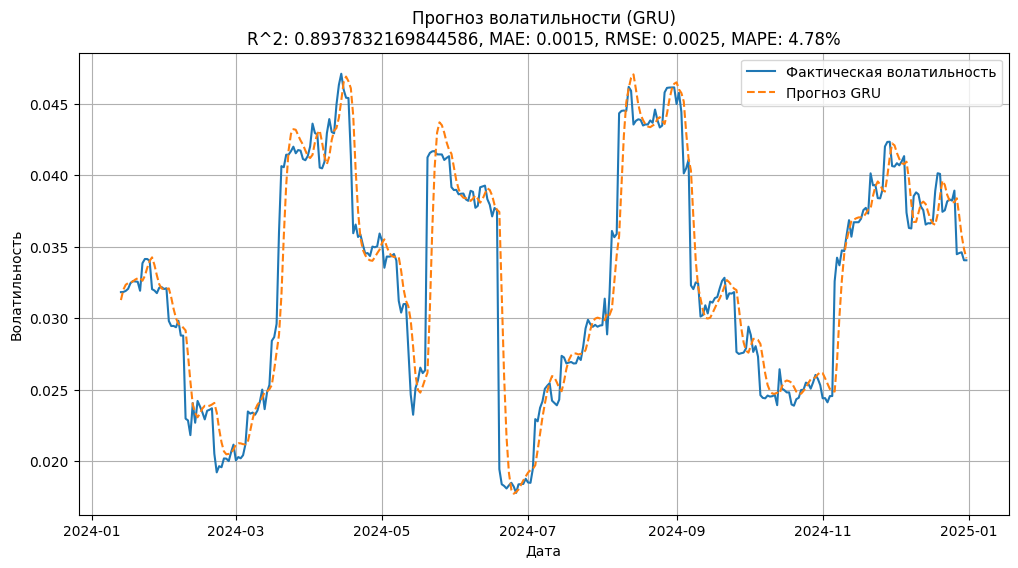

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

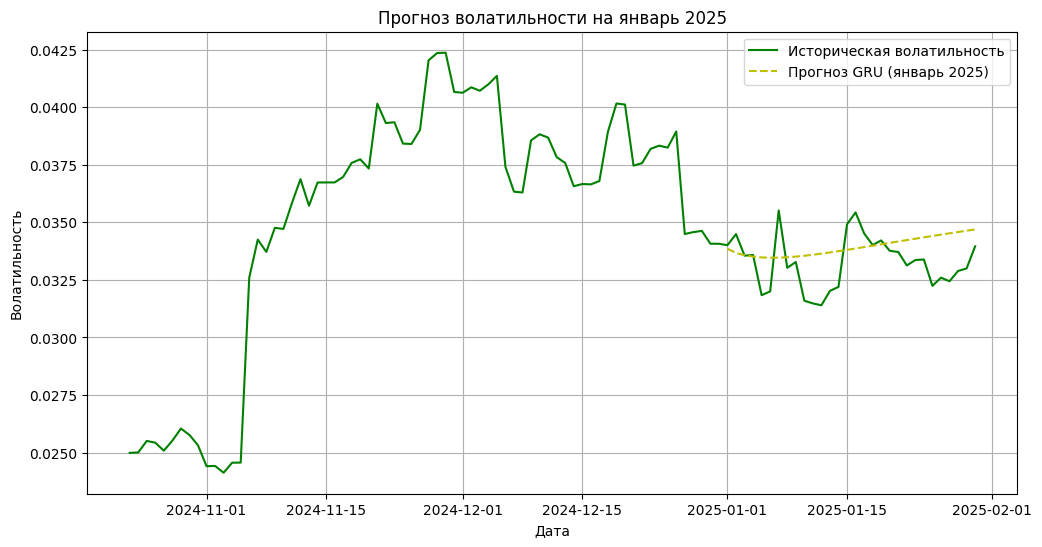

In [162]:
# Установка SEED для воспроизводимости
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tfrandom.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Отключаем GPU для детерминированности

# Нормализация данных (масштабирование к [0, 1])
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data[['Historical_Volatility']].dropna().values)

# Подготовка данных для GRU (X = предыдущие значения, y = следующее значение)
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 30  # Используем 30 предыдущих дней для прогноза
X, y = create_dataset(scaled_data, look_back)

# Разделение на обучающую и тестовую выборки (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape для GRU: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Создание GRU-модели
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

# Callback'и
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Обучение
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Обратное масштабирование данных
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Оценка модели
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100  # В процентах

print(f"\nОценка модели GRU:")
print(f"- R^2: {r2:.6f}")
print(f"- MAE: {mae:.6f}")
print(f"- RMSE: {rmse:.6f}")
print(f"- MAPE: {mape:.2f}%")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_actual, label='Фактическая волатильность')
plt.plot(data.index[-len(y_test):], y_pred_actual, label='Прогноз GRU', linestyle='--')
plt.title(f"Прогноз волатильности (GRU)\nR^2: {r2}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid()
plt.show()

# Прогноз на 30 дней вперед (январь 2025)
def forecast_future(model, initial_sequence, steps=30):
    future_predictions = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(steps):
        next_pred = model.predict(current_sequence.reshape(1, look_back, 1))
        future_predictions.append(next_pred)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    
    return future_predictions

# Берем последние `look_back` значений для прогноза
last_sequence = scaled_data[-look_back:]
future_volatility_scaled = forecast_future(model, last_sequence, steps=30)
future_volatility = scaler.inverse_transform(np.array(future_volatility_scaled).reshape(-1, 1))

# Даты для будущего прогноза
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Формирование единого датасета
union_data = pd.concat([data[['Price', 'Log_Returns', 'Historical_Volatility']], df_test])

# Оценка прогноза
data_for_marks = union_data.reset_index().query('Date >= "2025-01-01"')
r2 = r2_score(data_for_marks['Historical_Volatility'], future_volatility)
mae = mean_absolute_error(data_for_marks['Historical_Volatility'], future_volatility)
rmse = np.sqrt(mean_squared_error(data_for_marks['Historical_Volatility'], future_volatility))
mape = mean_absolute_percentage_error(data_for_marks['Historical_Volatility'], future_volatility) * 100  # В процентах

print(f"\nОценка модели GRU:")
print(f"- R^2: {r2:.6f}")
print(f"- MAE: {mae:.6f}")
print(f"- RMSE: {rmse:.6f}")
print(f"- MAPE: {mape:.2f}%")

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(union_data.index[-100:], union_data[['Historical_Volatility']].dropna().values[-100:], label='Историческая волатильность', color='g')
plt.plot(future_dates, future_volatility, '--y', label='Прогноз GRU (январь 2025)')
plt.title('Прогноз волатильности на январь 2025')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid()
plt.show()

Трансформер


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.8069 - mae: 0.6331 - mape: 2971482.7500 - val_loss: 0.0497 - val_mae: 0.1838 - val_mape: 25.2972 - learning_rate: 5.0000e-04
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.3324 - mae: 0.3596 - mape: 468312.5000 - val_loss: 0.0332 - val_mae: 0.1476 - val_mape: 22.2017 - learning_rate: 5.0000e-04
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.1360 - mae: 0.2553 - mape: 65390.4414 - val_loss: 0.0616 - val_mae: 0.2047 - val_mape: 24.9006 - learning_rate: 5.0000e-04
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.2626 - mae: 0.2977 - mape: 296307.1875 - val_loss: 0.0373 - val_mae: 0.1543 - val_mape: 19.6920 - learning_rate: 5.0000e-04
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.1552 - mae: 0.2542 - mape: 59322.6289 - val_loss: 0.1598 - val_mae: 0.3571 - val_mape: 43.1711 - learning_rate: 5.0000e-04
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.1810 - 

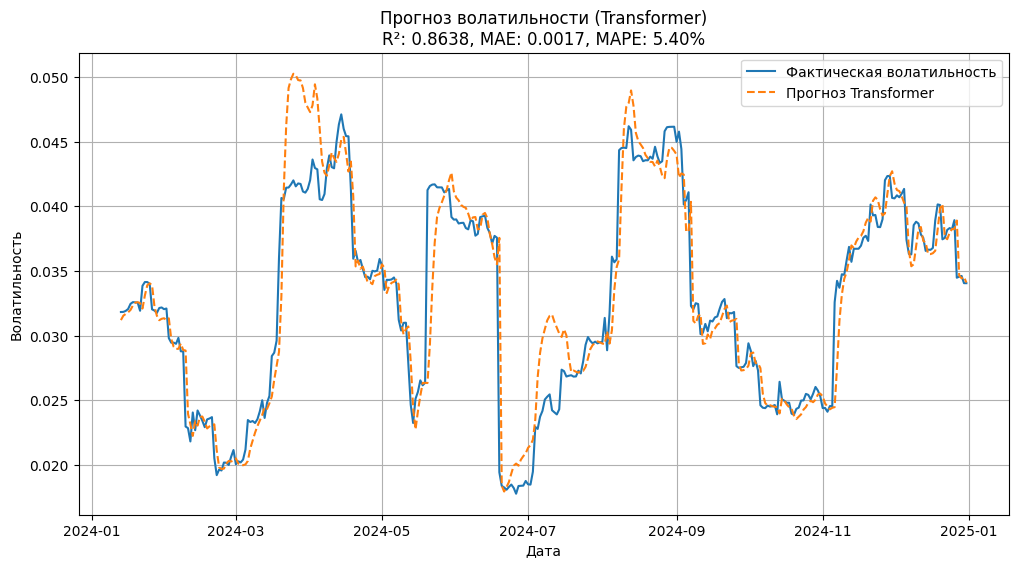


Долгосрочный прогноз (январь 2025):
- R²: -2.3266303197195755
- MAPE: 5.32%


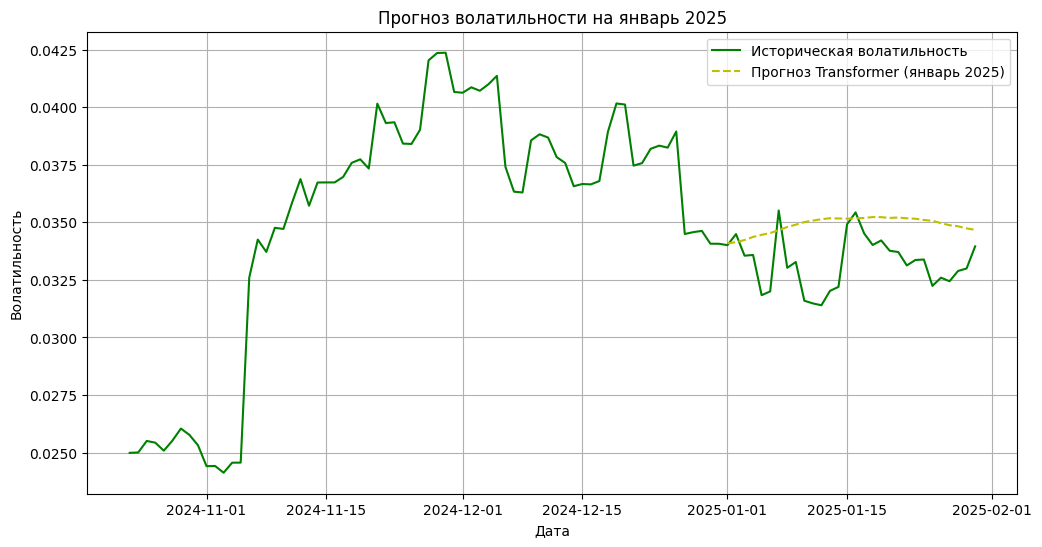

In [ ]:
# Установка SEED для воспроизводимости
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tfrandom.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Отключаем GPU для детерминированности

# Позиционное кодирование
class PositionalEncoding(Layer):
    def __init__(self, look_back=30, d_model=64, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.look_back = look_back
        self.d_model = d_model

    def build(self, input_shape):
        position = np.arange(input_shape[1])[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * - (np.log(10000.0) / self.d_model))
        pe = np.zeros((1, input_shape[1], self.d_model))
        pe[0, :, 0::2] = np.sin(position * div_term)
        pe[0, :, 1::2] = np.cos(position * div_term)
        self.positional_encoding = tf.constant(pe, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super().get_config()
        config.update({
            'look_back': self.look_back,
            'd_model': self.d_model
        })
        return config

# Блок трансформера
def transformer_encoder_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head Attention
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-forward network
    ffn = Sequential([
        Dense(ff_dim, activation='relu'),
        Dense(out1.shape[-1])
    ])
    ffn_output = ffn(out1)
    ffn_output = Dropout(dropout)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return out2

# Подготовка данных
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data[['Historical_Volatility']].dropna())

look_back = 30

def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, look_back)

# Разделение выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape для Transformer: [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Архитектура модели
def build_transformer_model(input_shape=(look_back, 1), head_size=256, num_heads=16, ff_dim=64,
                            num_transformer_blocks=2, mlp_units=[128, 64], dropout=0.2):
    inputs = Input(shape=input_shape)
    
    # Добавляем позиционное кодирование
    x = PositionalEncoding(look_back=input_shape[0], d_model=head_size)(inputs)
    
    # Несколько блоков внимания
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_block(x, head_size, num_heads, ff_dim, dropout)
    
    # Глобальное усреднение и полносвязные слои
    x = GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = Dense(dim, activation='relu')(x)
        x = Dropout(dropout)(x)
    outputs = Dense(1)(x)

    return Model(inputs, outputs)

# Создание и компиляция модели
transformer_model = build_transformer_model(
    input_shape=(look_back, 1),
    head_size=128,
    num_heads=8,
    ff_dim=64,
    num_transformer_blocks=2,
    mlp_units=[128, 64],
    dropout=0.2
)

transformer_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae', 'mape']
)

# Callback'и
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Обучение
history = transformer_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Прогнозирование
y_pred = transformer_model.predict(X_test)

# Обратное масштабирование
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler.inverse_transform(y_pred).flatten()

# Оценка метрик
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100

print(f"\nОценка модели Transformer:")
print(f"- R²: {r2:.6f}")
print(f"- MAE: {mae:.6f}")
print(f"- RMSE: {rmse:.6f}")
print(f"- MAPE: {mape:.2f}%")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_actual, label='Фактическая волатильность')
plt.plot(data.index[-len(y_test):], y_pred_actual, label='Прогноз Transformer', linestyle='--')
plt.title(f"Прогноз волатильности (Transformer)\nR²: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid(True)
plt.show()

# Прогноз на будущее
def forecast_future(model, initial_sequence, steps=30, noise_level=0.001):
    current_sequence = initial_sequence.copy()
    future_predictions = []

    for _ in range(steps):
        next_pred = model.predict(current_sequence.reshape(1, look_back, 1), verbose=0)
        next_pred += np.random.normal(0, noise_level)
        future_predictions.append(next_pred[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
        
    return np.array(future_predictions)

last_sequence = scaled_data[-look_back:]
future_volatility_scaled = forecast_future(transformer_model, last_sequence, steps=30)
future_volatility = scaler.inverse_transform(future_volatility_scaled.reshape(-1, 1))

# Даты и график
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

union_data = pd.concat([data[['Historical_Volatility']], df_test])

# Оценка прогноза
data_for_marks = union_data.reset_index().query('Date >= "2025-01-01"')['Historical_Volatility'].values

if len(data_for_marks) == len(future_volatility):
    r2_future = r2_score(data_for_marks, future_volatility[:, 0])
    mape_future = mean_absolute_percentage_error(data_for_marks, future_volatility[:, 0]) * 100
else:
    r2_future = "N/A"
    mape_future = "N/A"

print(f"\nДолгосрочный прогноз (январь 2025):")
print(f"- R²: {r2_future}")
print(f"- MAPE: {mape_future:.2f}%")

# Визуализация долгосрочного прогноза
plt.figure(figsize=(12, 6))
plt.plot(union_data.index[-100:], union_data['Historical_Volatility'].tail(100), label='Историческая волатильность', color='g')
plt.plot(future_dates, future_volatility, '--y', label='Прогноз Transformer (январь 2025)')
plt.title('Прогноз волатильности на январь 2025')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid(True)
plt.show()